# MNIST Using convolution

This is a stipped down version of MNIST.  We will learn how to recognize a 6!

For this demo to work you'll need to download the mnist dataset from [here](http://yann.lecun.com/exdb/mnist/)
and place them in `notebooks/data/`

In [1]:
## Helper function to read the MNIST data set

import os
import struct
import numpy as np

"""
Loosely inspired by http://abel.ee.ucla.edu/cvxopt/_downloads/mnist.py
which is GPL licensed.
"""

def read(dataset = 'training', path = './data', seperator = '-'):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    if dataset is 'training':
        fname_img = os.path.join(path, 'train-images'+seperator+'idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels'+seperator+'idx1-ubyte')
    elif dataset is 'testing':
        fname_img = os.path.join(path, 't10k-images'+seperator+'idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels'+seperator+'idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        tmp = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)
        tmp2 = np.array(tmp).astype('float')
        img = [ x / 255 for x in tmp2 ]
        

    get_img = lambda idx: (lbl[idx], img[idx])

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_img(i)

def show(image):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    from matplotlib import pyplot
    import matplotlib as mpl
    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    pyplot.show()

We are going to train and get really good at recognizing this 6

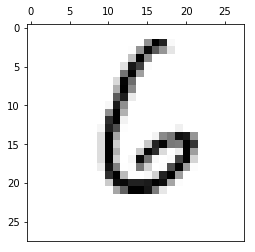

In [2]:
mnist = read('training','data','.')
#mnist = read('training')
mnist = list(mnist)
label, pixels = mnist[32] ## random 6 i found
show(pixels)

In [3]:
def onehot(label,nb_labels=10):
    out = np.zeros(nb_labels)
    out[label-1]=1
    return out

In [4]:
samples = 15
pics = [x[1]for x in mnist[:samples]]
labels = [onehot(x[0]) for x in mnist[:samples]]

In [5]:
#openmined imports:
import syft
import syft.nn as nn
import syft.controller
import imp
imp.reload(syft.controller)
imp.reload(syft.nn)
imp.reload(syft)
from syft import FloatTensor

### Our data

In [6]:
data = FloatTensor(pics,autograd=True)
target = FloatTensor(labels).autograd(True)
pic_size = data.shape()[1:3]
data.shape(),target.shape(),pic_size

([15, 28, 28], [15, 10], [28, 28])

### Our model

In [7]:
model = nn.Sequential()
model.add(nn.View(samples,1,pic_size[0],pic_size[1]))
model.add(nn.Conv2d(1,1,7))
model.add(nn.Sigmoid())
model.add(nn.Conv2d(1,1,7))
model.add(nn.Sigmoid())
model.add(nn.View(samples,16*16))
model.add(nn.Linear(16*16,25))
model.add(nn.Sigmoid())
model.add(nn.Linear(5*5,10))
model.add(nn.Sigmoid())

In [8]:
#pre-training
pred = model(data)
pred.shape(),target.shape()

([15, 10], [15, 10])

Train our model to become a pro at that digits

In [9]:
%%timeit #-n 3

pred = model(data)
loss = (pred - target) ** 2 # Mean Squared Error Loss

loss.backward()

for i,p in enumerate(model.parameters()):
    if p.autograd():
        p -= p.grad()

print(loss.to_numpy().sum())

65.6375493785
15.0665049064
14.9749110703
14.9965804033
14.9993906205
14.9998584273
14.9999621704
14.9999892075
6.79 s ± 198 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
example = 1
pred.to_numpy()[example],target.to_numpy()[example]

(array([ 0.6686268 ,  0.2665654 ,  0.9498549 ,  0.268577  ,  0.616451  ,
         0.9752122 ,  0.8174934 ,  0.4225313 ,  0.7959878 ,  0.05409032]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]))

Now, let's find a different 6 in the data and see how well we can recognize that

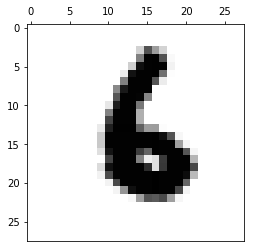

In [19]:
other_label, other_pixels = mnist[36] ## a different random 6 i found
show(other_pixels)
other_six = FloatTensor(other_pixels).view(1, 28,28).autograd(True)

In [ ]:
#this doesn't work yet, need batch support
pred = model(other_six)
pred

Check out the 6th element of the array!

## Simple examples

In [21]:
#openmined imports:
import syft
import syft.nn as nn
import syft.controller
import imp
imp.reload(syft.controller)
imp.reload(syft.nn)
imp.reload(syft)
from syft import FloatTensor

In [22]:
data = FloatTensor( [[[[1,0],[0,1]]]],autograd=1)
target = FloatTensor( [[[[2,1]]]],autograd=1)
model = nn.Conv2d(1,1,(2,1))
model(data),target

([[[[ 0.9993694  0.5485256]]]]
 [syft.FloatTensor:579 grad:None size:1x1x1x2]
 
 	-----------creators-----------
 	[syft.FloatTensor:571 grad:None size:1x1x2x2]
 	[syft.FloatTensor:577 grad:None size:1x2x1]
 	[syft.FloatTensor:578 grad:None size:1]
 	[syft.FloatTensor:573 grad:None size:2]
 	[syft.FloatTensor:574 grad:None size:2]
 	[syft.FloatTensor:575 grad:None size:2]
 	[syft.FloatTensor:576 grad:None size:1]
 	------------------------------
 
 , [[[[ 2.  1.]]]]
 [syft.FloatTensor:572 grad:None size:1x1x1x2])

In [23]:
data = FloatTensor( [[[[1,0,1],[0,0,0],[0,1,0]]]],autograd=1)
target = FloatTensor( [[[[1,2],[1,0]]]],autograd=1)
model = nn.Conv2d(1,1,2)
model(data),target

([[[[ 0.9993694   0.5485256 ]
    [-0.07908762  0.3619677 ]]]]
 [syft.FloatTensor:606 grad:None size:1x1x2x2]
 
 	-----------creators-----------
 	[syft.FloatTensor:598 grad:None size:1x1x3x3]
 	[syft.FloatTensor:604 grad:None size:1x2x2]
 	[syft.FloatTensor:605 grad:None size:1]
 	[syft.FloatTensor:600 grad:None size:2]
 	[syft.FloatTensor:601 grad:None size:2]
 	[syft.FloatTensor:602 grad:None size:2]
 	[syft.FloatTensor:603 grad:None size:1]
 	------------------------------
 
 , [[[[ 1.  2.]
    [ 1.  0.]]]]
 [syft.FloatTensor:599 grad:None size:1x1x2x2])

In [24]:
model.parameters()

[[[[ 0.9993694   0.5485256 ]
   [ 0.3619677  -0.07908762]]]
 [syft.FloatTensor:604 grad:None size:1x2x2]
 
 	-----------children-----------
 	[syft.FloatTensor:606 grad:None size:1x1x2x2]
 	------------------------------
 
 , [ 0.]
 [syft.FloatTensor:605 grad:None size:1], [ 1.  1.]
 [syft.FloatTensor:600 grad:None size:2], [ 0.  0.]
 [syft.FloatTensor:601 grad:None size:2], [ 1.  1.]
 [syft.FloatTensor:602 grad:None size:2], [ 1.]
 [syft.FloatTensor:603 grad:None size:1]]

In [25]:
pred = model(data)
print(pred.shape(),target.shape())
loss = (pred - target)# ** 2 # Mean Squared Error Loss
loss.backward()
loss.grad()

[1, 1, 2, 2] [1, 1, 2, 2]


[[[[ 1.  1.]
   [ 1.  1.]]]]
[syft.FloatTensor:643 grad:None size:1x1x2x2]

In [26]:
loss,model.parameters()[0],model.parameters()[0].grad()

([[[[ -6.30617100e-04  -1.45147400e+00]
    [ -1.07908800e+00   3.61967700e-01]]]]
 [syft.FloatTensor:642 grad:643 size:1x1x2x2]
 
 	-----------creators-----------
 	[syft.FloatTensor:639 grad:644 size:1x1x2x2]
 	[syft.FloatTensor:599 grad:652 size:1x1x2x2]
 	------------------------------
 
 , [[[ 0.9993694   0.5485256 ]
   [ 0.3619677  -0.07908762]]]
 [syft.FloatTensor:604 grad:651 size:1x2x2]
 
 	-----------children-----------
 	[syft.FloatTensor:606 grad:None size:1x1x2x2]
 [syft.FloatTensor:639 grad:644 size:1x1x2x2]
 	------------------------------
 
 , [[[ 1.  1.]
   [ 1.  1.]]]
 [syft.FloatTensor:651 grad:None size:1x2x2])

In [27]:
loss.grad()
model.parameters()[0].grad()

[[[ 1.  1.]
  [ 1.  1.]]]
[syft.FloatTensor:651 grad:None size:1x2x2]

In [29]:
#above, I would like to see the backpropped error, not a backprop of ones

In [28]:
%%timeit -n 3

pred = model(data)
loss = (pred - target) ** 2 # Mean Squared Error Loss

loss.backward()

for i,p in enumerate(model.parameters()):
    if p.autograd():
        print( p.grad().to_numpy())
        p -= p.grad()*0.01

#print(loss.to_numpy().sum())
print(loss.to_numpy())

[[[ 0.9987388 -1.902949 ]
  [ 1.723935  -1.158175 ]]]
[[[[  3.97678000e-07   2.10677800e+00]
   [  1.16443000e+00   1.31020600e-01]]]]
[[[ 0.9775027 -4.767838 ]
  [ 2.413392  -3.293187 ]]]
[[[[  1.12742600e-04   2.05189800e+00]
   [  1.13956900e+00   1.18837600e-01]]]]
[[[ 0.9367166 -7.537372 ]
  [ 3.054581  -5.362335 ]]]
[[[[  4.15877400e-04   1.91757800e+00]
   [  1.07034300e+00   1.02780800e-01]]]]
[[[  0.8771961 -10.15616  ]
  [  3.634678   -7.324236 ]]]
[[[[  8.85672000e-04   1.71450900e+00]
   [  9.62264200e-01   8.41281900e-02]]]]
[[[  0.8001317 -12.57182  ]
  [  4.142082   -9.139653 ]]]
[[[[ 0.00148473  1.458856  ]
   [ 0.8239343   0.0643646 ]]]]
[[[  0.7070646 -14.73605  ]
  [  4.566644  -10.77228  ]]]
[[[[ 0.00216537  1.170969  ]
   [ 0.6663648   0.04506322]]]]
[[[  0.5998563 -16.60555  ]
  [  4.899873  -12.18946  ]]]
[[[[ 0.00287341  0.8737624 ]
   [ 0.5020983   0.02776041]]]]
[[[  0.4806508 -18.14294  ]
  [  5.135104  -13.36284  ]]]
[[[[ 0.00355249  0.5908951 ]
   [ 0.34421